In [1]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

2022-08-02 15:24:19.097994: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
readout_mode = 'softmax'
# readout_mode = 'sample'
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'

In [3]:
n = 8
n_node = 8

In [4]:
K = tc.set_backend('jax')

In [5]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_test == 8
x_test, y_test = x_test[~ind], y_test[~ind]

x_train = x_train / 255.0
if encoding_mode == 'vanilla':
    mean = 0
elif encoding_mode == 'mean':
    mean = jnp.mean(x_train, axis=0)
elif encoding_mode == 'half':
    mean = 0.5
x_train = x_train - mean
x_test = x_test / 255.0
x_test = x_test - mean


def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = jax.nn.one_hot(y, n_node)
    return x, y

In [6]:
def clf(params, c, k):
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    return c

def readout(c):
    if readout_mode == 'softmax':
        logits = []
        for i in range(n_node):
            logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
        logits = jnp.stack(logits, axis=-1) * 10
        probs = jax.nn.softmax(logits)
    elif readout_mode == 'sample':
        wf = jnp.abs(c.wavefunction()[:n_node])**2
        probs = wf / jnp.sum(wf)
    return probs

In [7]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return -jnp.mean(y * jnp.log(probs))
loss = K.jit(loss, static_argnums=[3])

In [8]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

In [9]:
k = 6

In [10]:
compute_loss = K.jit(K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2]), static_argnums=[3])
compute_accuracy = K.jit(K.vmap(accuracy, vectorized_argnums=[1, 2]), static_argnums=[3])

  0%|          | 0/7 [00:00<?, ?it/s]

2022-08-02 15:24:31.161836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 15:24:33.755605: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-02 15:24:33.755667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30169 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:12:00.0, compute capability: 7.0


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/94: loss=0.1976, acc=0.4297
epoch 0, 20/94: loss=0.0826, acc=0.7969
epoch 0, 40/94: loss=0.0477, acc=0.9297
epoch 0, 60/94: loss=0.0299, acc=0.9531
epoch 0, 80/94: loss=0.0248, acc=0.9609
epoch 1, 0/94: loss=0.0220, acc=0.9688
epoch 1, 20/94: loss=0.0209, acc=0.9688
epoch 1, 40/94: loss=0.0212, acc=0.9609
epoch 1, 60/94: loss=0.0167, acc=0.9688
epoch 1, 80/94: loss=0.0169, acc=0.9609
epoch 2, 0/94: loss=0.0165, acc=0.9688
epoch 2, 20/94: loss=0.0166, acc=0.9531
epoch 2, 40/94: loss=0.0174, acc=0.9688
epoch 2, 60/94: loss=0.0095, acc=0.9922
epoch 2, 80/94: loss=0.0127, acc=0.9844
epoch 3, 0/94: loss=0.0163, acc=0.9453
epoch 3, 20/94: loss=0.0165, acc=0.9375
epoch 3, 40/94: loss=0.0133, acc=0.9688
epoch 3, 60/94: loss=0.0106, acc=0.9844
epoch 3, 80/94: loss=0.0091, acc=0.9922
epoch 4, 0/94: loss=0.0144, acc=0.9609
epoch 4, 20/94: loss=0.0138, acc=0.9844
epoch 4, 40/94: loss=0.0107, acc=0.9844
epoch 4, 60/94: loss=0.0136, acc=0.9531
epoch 4, 80/94: loss=0.0155, acc=0.9766


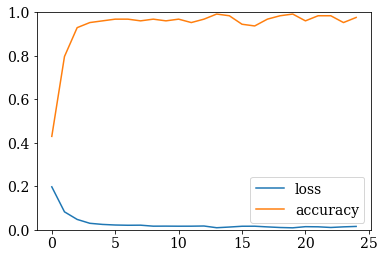

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/94: loss=0.4612, acc=0.0000
epoch 0, 20/94: loss=0.0996, acc=0.6016
epoch 0, 40/94: loss=0.0589, acc=0.9453
epoch 0, 60/94: loss=0.0410, acc=0.9453
epoch 0, 80/94: loss=0.0387, acc=0.9453
epoch 1, 0/94: loss=0.0302, acc=0.9688
epoch 1, 20/94: loss=0.0290, acc=0.9531
epoch 1, 40/94: loss=0.0267, acc=0.9609
epoch 1, 60/94: loss=0.0280, acc=0.9375
epoch 1, 80/94: loss=0.0295, acc=0.9297
epoch 2, 0/94: loss=0.0228, acc=0.9844
epoch 2, 20/94: loss=0.0290, acc=0.9375
epoch 2, 40/94: loss=0.0279, acc=0.9219
epoch 2, 60/94: loss=0.0189, acc=0.9609
epoch 2, 80/94: loss=0.0212, acc=0.9531
epoch 3, 0/94: loss=0.0169, acc=0.9688
epoch 3, 20/94: loss=0.0185, acc=0.9531
epoch 3, 40/94: loss=0.0214, acc=0.9453
epoch 3, 60/94: loss=0.0216, acc=0.9453
epoch 3, 80/94: loss=0.0210, acc=0.9531
epoch 4, 0/94: loss=0.0176, acc=0.9609
epoch 4, 20/94: loss=0.0154, acc=0.9688
epoch 4, 40/94: loss=0.0210, acc=0.9375
epoch 4, 60/94: loss=0.0190, acc=0.9531
epoch 4, 80/94: loss=0.0166, acc=0.9531


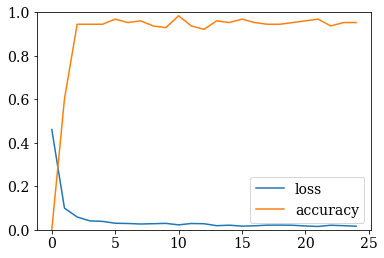

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/94: loss=0.2960, acc=0.1250
epoch 0, 20/94: loss=0.1280, acc=0.5469
epoch 0, 40/94: loss=0.0805, acc=0.7891
epoch 0, 60/94: loss=0.0516, acc=0.8984
epoch 0, 80/94: loss=0.0508, acc=0.8750
epoch 1, 0/94: loss=0.0544, acc=0.8281
epoch 1, 20/94: loss=0.0441, acc=0.8438
epoch 1, 40/94: loss=0.0476, acc=0.8359
epoch 1, 60/94: loss=0.0391, acc=0.8828
epoch 1, 80/94: loss=0.0370, acc=0.9062
epoch 2, 0/94: loss=0.0467, acc=0.8359
epoch 2, 20/94: loss=0.0363, acc=0.8828
epoch 2, 40/94: loss=0.0373, acc=0.8672
epoch 2, 60/94: loss=0.0302, acc=0.9375
epoch 2, 80/94: loss=0.0330, acc=0.9141
epoch 3, 0/94: loss=0.0411, acc=0.8516
epoch 3, 20/94: loss=0.0346, acc=0.8750
epoch 3, 40/94: loss=0.0382, acc=0.8672
epoch 3, 60/94: loss=0.0315, acc=0.9453
epoch 3, 80/94: loss=0.0349, acc=0.8984
epoch 4, 0/94: loss=0.0402, acc=0.8594
epoch 4, 20/94: loss=0.0294, acc=0.9219
epoch 4, 40/94: loss=0.0312, acc=0.9297
epoch 4, 60/94: loss=0.0372, acc=0.8750
epoch 4, 80/94: loss=0.0390, acc=0.8984


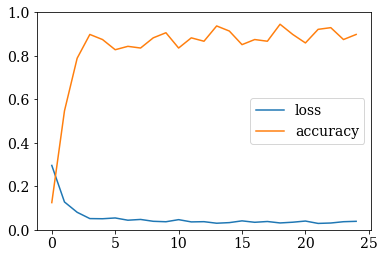

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/94: loss=0.1587, acc=0.5625
epoch 0, 20/94: loss=0.0669, acc=0.8750
epoch 0, 40/94: loss=0.0411, acc=0.9141
epoch 0, 60/94: loss=0.0320, acc=0.9297
epoch 0, 80/94: loss=0.0231, acc=0.9766
epoch 1, 0/94: loss=0.0267, acc=0.9531
epoch 1, 20/94: loss=0.0248, acc=0.9609
epoch 1, 40/94: loss=0.0204, acc=0.9688
epoch 1, 60/94: loss=0.0186, acc=0.9688
epoch 1, 80/94: loss=0.0189, acc=0.9688
epoch 2, 0/94: loss=0.0152, acc=0.9844
epoch 2, 20/94: loss=0.0159, acc=0.9766
epoch 2, 40/94: loss=0.0233, acc=0.9531
epoch 2, 60/94: loss=0.0157, acc=0.9766
epoch 2, 80/94: loss=0.0169, acc=0.9688
epoch 3, 0/94: loss=0.0118, acc=0.9922
epoch 3, 20/94: loss=0.0233, acc=0.9453
epoch 3, 40/94: loss=0.0180, acc=0.9688
epoch 3, 60/94: loss=0.0146, acc=0.9844
epoch 3, 80/94: loss=0.0150, acc=0.9766
epoch 4, 0/94: loss=0.0159, acc=0.9844
epoch 4, 20/94: loss=0.0152, acc=0.9688
epoch 4, 40/94: loss=0.0128, acc=0.9844
epoch 4, 60/94: loss=0.0177, acc=0.9375
epoch 4, 80/94: loss=0.0164, acc=0.9766


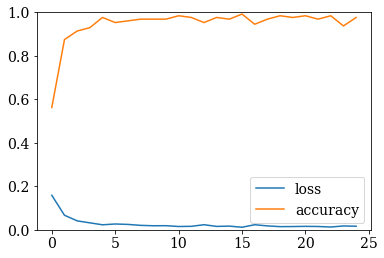

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/94: loss=0.4452, acc=0.2734
epoch 0, 20/94: loss=0.1891, acc=0.4375
epoch 0, 40/94: loss=0.0905, acc=0.8438
epoch 0, 60/94: loss=0.0419, acc=0.9375
epoch 0, 80/94: loss=0.0221, acc=1.0000
epoch 1, 0/94: loss=0.0199, acc=0.9922
epoch 1, 20/94: loss=0.0164, acc=0.9844
epoch 1, 40/94: loss=0.0142, acc=0.9766
epoch 1, 60/94: loss=0.0080, acc=1.0000
epoch 1, 80/94: loss=0.0075, acc=1.0000
epoch 2, 0/94: loss=0.0118, acc=0.9844
epoch 2, 20/94: loss=0.0138, acc=0.9844
epoch 2, 40/94: loss=0.0083, acc=0.9922
epoch 2, 60/94: loss=0.0061, acc=1.0000
epoch 2, 80/94: loss=0.0060, acc=0.9922
epoch 3, 0/94: loss=0.0049, acc=1.0000
epoch 3, 20/94: loss=0.0072, acc=0.9922
epoch 3, 40/94: loss=0.0066, acc=0.9922
epoch 3, 60/94: loss=0.0041, acc=1.0000
epoch 3, 80/94: loss=0.0050, acc=1.0000
epoch 4, 0/94: loss=0.0077, acc=0.9922
epoch 4, 20/94: loss=0.0055, acc=0.9922
epoch 4, 40/94: loss=0.0051, acc=0.9922
epoch 4, 60/94: loss=0.0059, acc=0.9922
epoch 4, 80/94: loss=0.0041, acc=0.9922


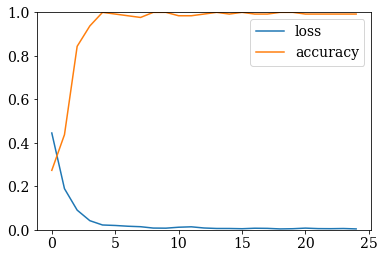

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/94: loss=0.4001, acc=0.0000
epoch 0, 20/94: loss=0.1152, acc=0.7109
epoch 0, 40/94: loss=0.0722, acc=0.7734
epoch 0, 60/94: loss=0.0657, acc=0.8047
epoch 0, 80/94: loss=0.0636, acc=0.8047
epoch 1, 0/94: loss=0.0562, acc=0.8125
epoch 1, 20/94: loss=0.0534, acc=0.8359
epoch 1, 40/94: loss=0.0625, acc=0.7734
epoch 1, 60/94: loss=0.0541, acc=0.8281
epoch 1, 80/94: loss=0.0458, acc=0.8594
epoch 2, 0/94: loss=0.0494, acc=0.8203
epoch 2, 20/94: loss=0.0553, acc=0.7891
epoch 2, 40/94: loss=0.0463, acc=0.8516
epoch 2, 60/94: loss=0.0484, acc=0.8594
epoch 2, 80/94: loss=0.0580, acc=0.7891
epoch 3, 0/94: loss=0.0538, acc=0.7734
epoch 3, 20/94: loss=0.0522, acc=0.7812
epoch 3, 40/94: loss=0.0492, acc=0.8438
epoch 3, 60/94: loss=0.0549, acc=0.7891
epoch 3, 80/94: loss=0.0527, acc=0.8203
epoch 4, 0/94: loss=0.0438, acc=0.8594
epoch 4, 20/94: loss=0.0517, acc=0.7656
epoch 4, 40/94: loss=0.0519, acc=0.8281
epoch 4, 60/94: loss=0.0511, acc=0.8203
epoch 4, 80/94: loss=0.0488, acc=0.8125


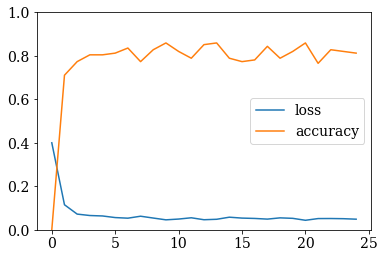

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/94: loss=0.1876, acc=0.4688
epoch 0, 20/94: loss=0.0430, acc=0.9688
epoch 0, 40/94: loss=0.0187, acc=0.9844
epoch 0, 60/94: loss=0.0114, acc=0.9922
epoch 0, 80/94: loss=0.0071, acc=1.0000
epoch 1, 0/94: loss=0.0059, acc=1.0000
epoch 1, 20/94: loss=0.0061, acc=0.9922
epoch 1, 40/94: loss=0.0047, acc=1.0000
epoch 1, 60/94: loss=0.0023, acc=1.0000
epoch 1, 80/94: loss=0.0030, acc=1.0000
epoch 2, 0/94: loss=0.0023, acc=1.0000
epoch 2, 20/94: loss=0.0038, acc=0.9922
epoch 2, 40/94: loss=0.0027, acc=1.0000
epoch 2, 60/94: loss=0.0015, acc=1.0000
epoch 2, 80/94: loss=0.0021, acc=1.0000
epoch 3, 0/94: loss=0.0015, acc=1.0000
epoch 3, 20/94: loss=0.0023, acc=1.0000
epoch 3, 40/94: loss=0.0016, acc=1.0000
epoch 3, 60/94: loss=0.0009, acc=1.0000
epoch 3, 80/94: loss=0.0026, acc=0.9922
epoch 4, 0/94: loss=0.0015, acc=1.0000
epoch 4, 20/94: loss=0.0041, acc=0.9922
epoch 4, 40/94: loss=0.0014, acc=1.0000
epoch 4, 60/94: loss=0.0006, acc=1.0000
epoch 4, 80/94: loss=0.0007, acc=1.0000


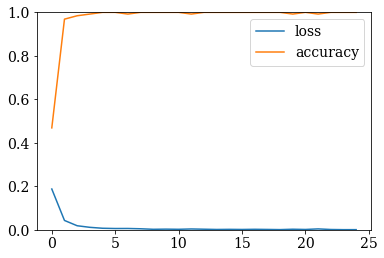

In [11]:
params_list = []
gmm_list = []
all_train_loss = []
all_train_acc = []
for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
    data = tf.data.Dataset.from_tensor_slices((x_train_small, y_train_node)).shuffle(100).batch(128)

    # GMM
    gmm = GaussianMixture(n_components=5, max_iter=100)
    gmm.fit(x_train_small)
    gmm_list.append(gmm)

    params = K.randn((k * 2, n), dtype=jnp.float32)
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)

    loss_list = []
    acc_list = []
    for e in tqdm(range(5), leave=False):
        for i, (x, y) in enumerate(data):
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params, x, y, k)
            updates, opt_state = opt.update(grad_val, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss_mean = jnp.mean(loss_val)
            if i % 20 == 0:
                acc = jnp.mean(compute_accuracy(params, x, y, k))
                acc_list.append(acc)
                loss_list.append(loss_mean)
                print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')
    all_train_loss.append(loss_list)
    all_train_acc.append(acc_list)
    

    plt.plot(loss_list)
    plt.plot(acc_list)
    plt.legend(['loss', 'accuracy'])
    plt.ylim(0, 1)
    plt.show()

    params_list.append(params)


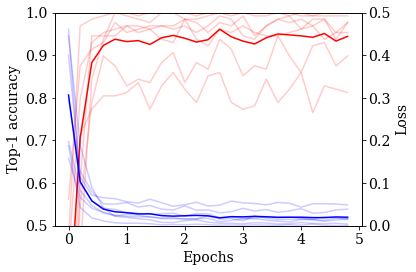

In [12]:
for acc_curve in all_train_acc:
    plt.plot(acc_curve, c='red', alpha=0.2)
avg_acc_curve = jnp.mean(jnp.array(all_train_acc), axis=0)
plt.plot(avg_acc_curve, c='red', label='accuracy')
plt.ylim(0.5, 1)
plt.ylabel('Top-1 accuracy')
plt.xlabel('Epochs')
plt.twinx()

for loss_curve in all_train_loss:
    plt.plot(loss_curve, c='blue', alpha=0.2)
avg_loss_curve = jnp.mean(jnp.array(all_train_loss), axis=0)
plt.plot(avg_loss_curve, c='blue', label='loss')
plt.ylim(0, 0.5)
plt.ylabel('Loss')

plt.xticks([0, 5, 10, 15, 20, 25], [0, 1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig('client_loss_acc_fashion.pdf')
plt.show()

In [13]:
def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return probs
# pred = K.jit(pred, static_argnums=[3])

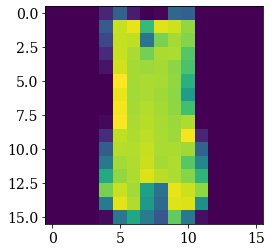

[1. 0. 0. 0. 0. 0. 0. 0.]


DeviceArray([0.25150466, 0.00102719, 0.0012087 , 0.7393404 , 0.00270182,
             0.00156246, 0.00085038, 0.00180445], dtype=float32)

In [14]:
i = 3
x_train_node, y_train_node = filter_pair(x_train, y_train, 0, 2 + 1)
x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
plt.imshow(x_train_small[i].reshape(16, 16))
plt.show()
print(y_train_node[i])
pred(params_list[2], x_train_small[i], k)

In [15]:
density_est_list = []
p_node = []
for node in tqdm(range(n_node-1)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
    x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
    dm = jnp.einsum('nij, njk -> nik', jnp.conjugate(x_train_small.reshape(-1, 2**n, 1)), x_train_small.reshape(-1, 1, 2**n))
    density_est_list.append(jnp.mean(dm, axis=0))
    p_node.append(len(x_train_small))
density_est_list = jnp.stack(density_est_list, axis=0)
p_node = jnp.stack(p_node, axis=0) / jnp.sum(jnp.array(p_node))

  0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
from itertools import combinations
trace_dist_list = []
for dm1, dm2 in combinations(density_est_list, 2):
    diff = dm1 - dm2
    eigenvals = jnp.linalg.eigh(diff)[0]
    trace_dist = jnp.sum(jnp.abs(eigenvals)) / 2
    trace_dist_list.append(trace_dist)
trace_dist_list = jnp.stack(trace_dist_list, axis=0)
print(trace_dist_list)
print(jnp.mean(trace_dist_list), jnp.std(trace_dist_list))
print((1 + jnp.mean(trace_dist_list)) / 2)

[0.32423306 0.18557309 0.29616535 0.44001585 0.29867023 0.4463812
 0.2747358  0.09174716 0.36788946 0.09843768 0.39186734 0.23920678
 0.41184026 0.22869343 0.42450917 0.37347215 0.08989985 0.392823
 0.36927456 0.22118926 0.39568934]
0.30296737 0.1128298
0.65148365


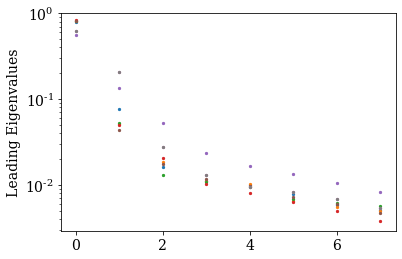

In [17]:
for i in range(n_node):
    plt.scatter(jnp.arange(8), jnp.linalg.eigh(density_est_list[i])[0][::-1][:8], s=5)
plt.yscale('log')
plt.ylabel('Leading Eigenvalues')
plt.ylim(top=1)
plt.show()

In [18]:
p_node

DeviceArray([0.14285713, 0.14285713, 0.14285713, 0.14285713, 0.14285713,
             0.14285713, 0.14285713], dtype=float32)

In [19]:
def pred_comb_with_gmm(params, x, gmm_scores, k, d_mode='GMM'):
    dm_list = []
    for node in range(n_node-1):
        c = tc.Circuit(n, inputs=x)
        c = clf(params[node], c, k)
        density_matrix = jnp.conjugate(c.wavefunction('ket')) @ c.wavefunction('bra')
        dm_list.append(density_matrix)

    if d_mode == 'DM':
        projector = jnp.conjugate(x.reshape(-1, 1)) @ x.reshape(1, -1)
        weight = jnp.einsum('nij, ji -> n', density_est_list, projector).reshape(-1, 1, 1) * p_node.reshape(-1, 1, 1)
        weight = (weight)**10
        weight = weight / jnp.sum(weight)
    elif d_mode == 'GMM':
        weight = jnp.exp(gmm_scores - jnp.max(gmm_scores)).reshape(-1) * p_node
        weight = weight / jnp.sum(weight)
        weight = weight.reshape(-1, 1, 1)
    else:
        print('d_mode must be DM or GMM')
        return None

    dm = jnp.sum(jnp.stack(dm_list, axis=0) * weight, axis=0)
    # print(jnp.trace(dm))
    if readout_mode == 'softmax':
        c = tc.DMCircuit(n, dminputs=dm)
        pred_prob = readout(c)
    elif readout_mode == 'sample':
        wf = jnp.abs(jnp.diag(dm)[:n_node])**2
        pred_prob = wf / jnp.sum(wf)
        
    return pred_prob
pred_comb_with_gmm = K.vmap(pred_comb_with_gmm, vectorized_argnums=[1, 2])

def pred_comb(params, x, k, d_mode='GMM'):
    gmm_scores_list = []
    for node in range(n_node-1):
        gmm_scores = gmm_list[node].score_samples(x)
        gmm_scores_list.append(gmm_scores)
    gmm_scores_list = jnp.stack(gmm_scores_list, axis=-1)
    
    pred_prob = pred_comb_with_gmm(params, x, gmm_scores_list, k, d_mode)
    return pred_prob


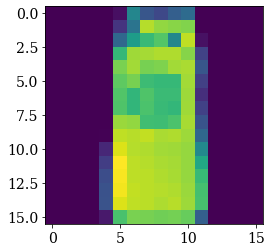

In [20]:
i = 37
x_train_node, y_train_node = filter_pair(x_train, y_train, 0, 2 + 1)
x_train_small = tf.image.resize(x_train_node[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))
plt.imshow(x_train_small[i].reshape(16, 16))

In [21]:
jnp.mean(pred_comb(params_list, x_train_small[:100], k, d_mode='GMM').argmax(axis=-1) == y_train_node[:100].argmax(axis=-1))

DeviceArray(0.84, dtype=float32)

In [22]:
jnp.mean(pred_comb(params_list, x_train_small[:100], k, d_mode='DM').argmax(axis=-1) == y_train_node[:100].argmax(axis=-1))

DeviceArray(0.57, dtype=float32)

In [23]:
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))

In [24]:
jnp.mean(pred_comb(params_list, x_test[:1024], k, d_mode='GMM').argmax(axis=-1) == y_test[:1024])

DeviceArray(0.75, dtype=float32)

In [25]:
-jnp.mean(jnp.log(pred_comb(params_list, x_test[:1024], k, d_mode='GMM'))*jax.nn.one_hot(y_test[:1024], n_node))

DeviceArray(0.1936221, dtype=float32)

In [26]:
jnp.mean(pred_comb(params_list, x_test[:1024], k, d_mode='DM').argmax(axis=-1) == y_test[:1024])

DeviceArray(0.3720703, dtype=float32)

In [27]:
-jnp.mean(jnp.log(pred_comb(params_list, x_test[:1024], k, d_mode='DM'))*jax.nn.one_hot(y_test[:1024], n_node))

DeviceArray(0.2614649, dtype=float32)